In [1]:
import torch
import numpy as np
import math
from torch_geometric.data import Data,Dataset,DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from IPython.display import clear_output
from torch.nn import Linear,Softmax
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,GENConv,CGConv,EdgePooling
from torch_geometric.nn import global_mean_pool,max_pool_neighbor_x,TopKPooling,global_max_pool
import sklearn
import copy
import pickle
import json


In [2]:




maxjets=10
sigfile = pd.read_json("sigimg.dat", lines=True,chunksize=maxjets)
bkgfile = pd.read_json("bkgimg.dat", lines=True,chunksize=maxjets)
batch_size=64
ntotjets=batch_size*int(8000/batch_size)
print(ntotjets)
nstot=0
nbtot=0
sdone=False
bdone=False
for il,(x1,x2) in enumerate(zip(sigfile,bkgfile)):

    x1filt = x1[ x1.iloc[:,2]>0.0]
    x2filt = x2[ x2.iloc[:,2]>0.0]
    nstot+=x1filt.shape[0]
    nbtot+=x2filt.shape[0]


    if il==0:
        fullset=pd.concat((x1filt,x2filt))
    else:
        if nstot<=ntotjets/2:
            fullset=pd.concat((fullset,x1filt))
        else:
            sdone=True
        if nbtot<=ntotjets/2:
            fullset=pd.concat((fullset,x2filt))
        else:
            bdone=True
    #print(fullset.shape[0],ntotjets,nstot,nbtot)
    if (bdone&sdone):
        break
print (fullset.shape)


8000
(7987, 4)


0 7987
10 7987
20 7987
30 7987
40 7987
50 7987
60 7987
70 7987
80 7987
90 7987
100 7987
110 7987
120 7987
130 7987
140 7987
150 7987
160 7987
170 7987
180 7987
190 7987
200 7987
210 7987
220 7987
230 7987
240 7987
250 7987
260 7987
270 7987
280 7987
290 7987
300 7987
310 7987
320 7987
330 7987
340 7987
350 7987
360 7987
370 7987
380 7987
390 7987
400 7987
410 7987
420 7987
430 7987
440 7987
450 7987
460 7987
470 7987
480 7987
490 7987
500 7987
510 7987
520 7987
530 7987
540 7987
550 7987
560 7987
570 7987
580 7987
590 7987
600 7987
610 7987
620 7987
630 7987
640 7987
650 7987
660 7987
670 7987
680 7987
690 7987
700 7987
710 7987
720 7987
730 7987
740 7987
750 7987
760 7987
770 7987
780 7987
790 7987
800 7987
810 7987
820 7987
830 7987
840 7987
850 7987
860 7987
870 7987
880 7987
890 7987
900 7987
910 7987
920 7987
930 7987
940 7987
950 7987
960 7987
970 7987
980 7987
990 7987
1000 7987
1010 7987
1020 7987
1030 7987
1040 7987
1050 7987
1060 7987
1070 7987
1080 7987
1090 7987
1100 7987
1

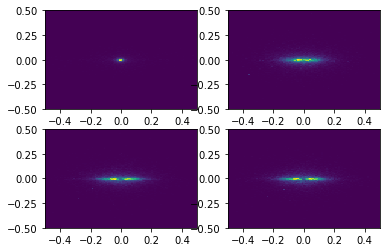

In [3]:

def principal_axis(partlist):
    tan_theta=0.0;
    M11=0.0;
    M20=0.0;
    M02=0.0;
    for i in range(len(partlist)):
        M11 += partlist[i].pt*partlist[i].phi*partlist[i].eta
        M20 += partlist[i].pt*partlist[i].phi*partlist[i].phi
        M02 += partlist[i].pt*partlist[i].eta*partlist[i].eta

    denom=(M20-M02+math.sqrt(4*M11*M11+(M20-M02)*(M20-M02)))
    if(denom!=0.0):
            tan_theta=2.0*M11/denom
    return tan_theta;


class part():
    def __init__(self,pt,eta,phi):
        self.pt=pt
        self.eta=eta
        self.phi=phi
def invm(p1,p2):
    return p1.pt*p2.pt*(math.cosh(p1.eta-p2.eta)-math.cos(p1.phi-p2.phi))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size=32

if True:
    totjets=(fullset.shape)[0]
    datas = []
    drarr=[]
    phiarr=[[],[],[],[],[],[],[],[],[],[]]
    etaarr=[[],[],[],[],[],[],[],[],[],[]]
    ptarr=[[],[],[],[],[],[],[],[],[],[]]
    jetptarr=[[],[]]
    jetmassarr=[[],[]]

    for ij,fullevt in enumerate(fullset.iloc):
        if ij%100==0:
            print (ij,totjets)
        #if ij==500:
         #   break

        jetval = fullevt.iloc[0]
        #print (ij,fullevt.iloc[1])
        #print(fullevt.iloc[1])
        jetid = torch.tensor(int(abs(int(fullevt.iloc[1]))>4))

        #print(jetid)
        #jetone=F.one_hot(jetid, num_classes=2)
        #print (jetid,jetone)
        partlist=[]
        edgelist=[[],[]]
        edgelist1=[[],[]]
        edgelist2=[[],[]]
        edgelist3=[[],[]]
        edgelist4=[[],[]]

        edgefeat=[]
        posm=[]
        ptsum=0.0
        particles=[]
        jindex=0
        deltaeta,deltaphi=0,0
        for ip in range(len(jetval)):
            particles.append([])
            for its in range(len(jetval[ip])):
                #print (jetval[ip][its])
                curp=part(jetval[ip][its][9],jetval[ip][its][3],jetval[ip][its][4])
                particles[-1].append(curp)
                partlist.append([curp.pt,curp.eta,curp.phi,its])
                
                ptsum+=curp.pt
                sindex=0

                for isp in range(len(jetval)):
                    for ists in range(len(jetval[isp])):
                        if (isp==ip):
                            edgelist[0].append(int(jindex))
                            edgelist[1].append(int(sindex))
                            continue
                        if (ists!=its):
                            continue
                        secp=part(jetval[isp][ists][9],jetval[isp][ists][3],jetval[isp][ists][4])

                        DR=math.sqrt((curp.eta-secp.eta)**2+(curp.phi-secp.phi)**2)
                        drarr.append(DR)

                        if (DR<0.02):
                            edgelist[0].append(int(jindex))
                            edgelist[1].append(int(sindex))

                            edgefeat.append([invm(curp,secp),curp.eta-secp.eta,curp.phi-secp.phi])
                            edgefeat.append([invm(curp,secp),curp.eta-secp.eta,curp.phi-secp.phi])
                        if (0.02<DR<0.05):
                            edgelist1[0].append(int(jindex))
                            edgelist1[1].append(int(sindex))

                        if (0.05<DR<0.1):
                            edgelist2[0].append(int(jindex))
                            edgelist2[1].append(int(sindex))

                        if (0.1<DR<0.2):
                            edgelist3[0].append(int(jindex))
                            edgelist3[1].append(int(sindex))

                        if (0.2<DR<0.4):
                            edgelist4[0].append(int(jindex))
                            edgelist4[1].append(int(sindex))
                        sindex+=1
                jindex+=1
                tan_theta=principal_axis(particles[0])

        lpt=0
        rpt=0
        
        for ipt,curpart in enumerate(particles[0]):
                            if curpart.eta>0:
                                lpt+=curpart.pt
                            else:
                                rpt+=curpart.pt

        for ipt,curpart in enumerate(particles[0]):  
                            if lpt>rpt:
                                flip=True
                            else:
                                flip=False
        pnum=0
        for itime,timestep in enumerate(particles):
                            for ipt,curpart in enumerate(timestep):

                                Reta = curpart.phi*math.cos(math.atan(tan_theta))+curpart.eta*math.sin(math.atan(tan_theta));
                                Rphi = -1.0*curpart.phi*math.sin(math.atan(tan_theta))+curpart.eta*math.cos(math.atan(tan_theta));
                                partlist[pnum][1]=Reta
                                partlist[pnum][2]=Rphi
                                curpart.eta=Reta
                                curpart.phi=Rphi
                                pnum+=1
        pnum=0

        for itime,timestep in enumerate(particles):
                            #print (len(timestep))
                            for ipt,curpart in enumerate(timestep):
                                if flip:
                                    curpart.eta=-1*curpart.eta
                                partlist[pnum][2]=curpart.phi
                                partlist[pnum][1]=curpart.eta
                                posm.append([curpart.eta,curpart.phi])
                                if jetid==1:
                                    #print (partlist[ipt][-1])
                                    phiarr[partlist[pnum][-1]].append(curpart.phi)
                                    etaarr[partlist[pnum][-1]].append(curpart.eta)
                                    ptarr[partlist[pnum][-1]].append(curpart.pt)
                                deltaeta,deltaphi
                                pnum+=1


        jetptarr[jetid].append(fullevt.iloc[-1])
        jetmassarr[jetid].append(fullevt.iloc[-2])
        
        datas.append(Data(x = torch.tensor(partlist, dtype=torch.float),pos=torch.tensor(posm, dtype=torch.float), edge_index1=torch.tensor(edgelist1, dtype=torch.long), edge_index2=torch.tensor(edgelist2, dtype=torch.long),edge_index3=torch.tensor(edgelist3, dtype=torch.long),edge_index4=torch.tensor(edgelist4, dtype=torch.long), edge_index=torch.tensor(edgelist, dtype=torch.long),y=jetid).to(device))
        TM=0
        if ip%3==0:
            TM=1
        datas[-1].test_mask=TM
    
    #plt.hist(etaarr,bins=100,range=[[-1,1],[-1,1]] )
    
    fig, axs = plt.subplots(2,2)
    axs[0][0].hist2d(etaarr[0],phiarr[0],bins=100,range=[[-0.5,0.5],[-0.5,0.5]],weights=ptarr[0] )
    axs[0][1].hist2d(etaarr[2],phiarr[2],bins=100,range=[[-0.5,0.5],[-0.5,0.5]],weights=ptarr[2] )
    axs[1][0].hist2d(etaarr[4],phiarr[4],bins=100,range=[[-0.5,0.5],[-0.5,0.5]],weights=ptarr[4] )
    axs[1][1].hist2d(etaarr[6],phiarr[6],bins=100,range=[[-0.5,0.5],[-0.5,0.5]],weights=ptarr[6] )

    #axs[1][0].hist(jetmassarr[0],bins=100,range=[0,2] )
    #axs[1][0].hist(jetmassarr[1],bins=100,range=[0,2] )
    #axs[1][1].hist(jetptarr[0],bins=100,range=[0,2] )
    #axs[1][1].hist(jetptarr[1],bins=100,range=[0,2] )
print ("Make DataLoader")

dataloader=DataLoader(datas,batch_size=batch_size, shuffle=True)
print ("Done")

In [4]:

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    #acc = torch.round(acc * 100)

    return acc
"""def CApool(datax,curfeat):
    datax.pos.shape
    newx=[]
    newedge=[]
    newedgefeat=[]
    newpos=[]
    gindex=0
    for ibatch in range (max(datax.batch)):
        print(ibatch)
        dataxbpos = datax.pos[datax.batch==ibatch]
        dataxbx = datax.x[datax.batch==ibatch]

        curfeatpos = curfeat[datax.batch==ibatch]

        merged=[]
        for ip,partval in enumerate(dataxbpos):
            if ip in merged:
                continue
            #print (partval,dataxbpos)
            drs=(torch.sqrt((partval[0]-dataxbpos[:,0])**2+(partval[1]-dataxbpos[:,1])**2))
            drs[drs==0.0]=999999.0
            merged.append(torch.argmin(drs))
            newx.append([curfeatpos[ip]+curfeatpos[merged[-1]]])
            newpos.append([torch.mean(dataxbx[ip,0]*dataxbx[ip,1],dataxbx[merged[-1],0]*dataxbx[merged[-1],1]),torch.mean(dataxbx[ip,0]*dataxbx[ip,2],dataxbx[merged[-1],0]*dataxbx[merged[-1],2])])
            gindex+=1
            
        for ip,partval in enumerate(newpos):
            for jp,secval in enumerate(newpos):

    return datax
"""
def reedge(xinput,DRval):
    print (xinput.shape)
    edgelist1=torch.zeros((2,xinput))
    for i1 in range(xinput.shape[0]):
        DR=torch.sqrt((xinput[i1,0]-xinput[:,0])**2+(xinput[i1,1]-xinput[:,1])**2)
        #print (torch.where(DR<0.1))
        tw=torch.where(DR<DRval)
        edgelist1[0].append(tw)
        #print(tw)
        edgelist1[1].append(i1*(torch.ones_like(tw[0])))
    print(len(edgelist1))
    return torch.tensor(edgelist1, dtype=torch.long).to(device)
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GENConv(4, 2*hidden_channels,num_layers=2)
        self.edgepool1=EdgePooling(2*hidden_channels,add_to_edge_score=0)

        self.conv2 = GENConv(2*hidden_channels, 2*hidden_channels,num_layers=2)
        self.edgepool2=EdgePooling(2*hidden_channels,add_to_edge_score=0)

        self.conv3 = GENConv(2*hidden_channels,2*hidden_channels,num_layers=2)
        self.edgepool3=EdgePooling(2*hidden_channels,add_to_edge_score=0)      

        self.conv4 = GENConv(2*hidden_channels,2*hidden_channels,num_layers=2)        
        self.conv5 = GENConv(2*hidden_channels,2*hidden_channels,num_layers=2)
 
        self.jflin =  Linear(23+1, 2*hidden_channels)
        self.convlin =  Linear(2*hidden_channels, 2*hidden_channels)

        self.lin0 =  Linear(2*hidden_channels, 2*hidden_channels)
        self.lin1 =  Linear(2*hidden_channels, hidden_channels)
        self.lin2 =  Linear(hidden_channels, 2)

    def forward(self, data):
        xinput, edge_index, edge_index1, edge_index2, edge_index3, edge_index4, batch, edge_attr =data.x, data.edge_index, data.edge_index1, data.edge_index2,data.edge_index3,data.edge_index4, data.batch, data.edge_attr
        #print(xinput.shape,edge_index.shape)
        #newedge = reedge(data.pos,0.05)
        x = self.conv1(xinput, edge_index)
        x = x.relu()

        #newedge = reedge(data.pos,0.1)        

        x = self.conv2(x, edge_index1)
        x = x.relu()

    
        x = self.conv3(x, edge_index2)
        x = x.relu()
 
        x = self.conv4(x, edge_index3)
        x = x.relu()
        
        x = self.conv5(x, edge_index4)
        x = x.relu()
        
        x = global_mean_pool(x, batch)
        x = self.convlin(x)
        x = x.relu()

        x = self.lin0(x)
        x = x.relu()


        x = self.lin1(x)
        x = x.relu()    
        x = F.dropout(x, p=0.5, training=self.training)
        

        x = F.log_softmax(self.lin2(x),dim=1)
        
        return x
    
    
    
    

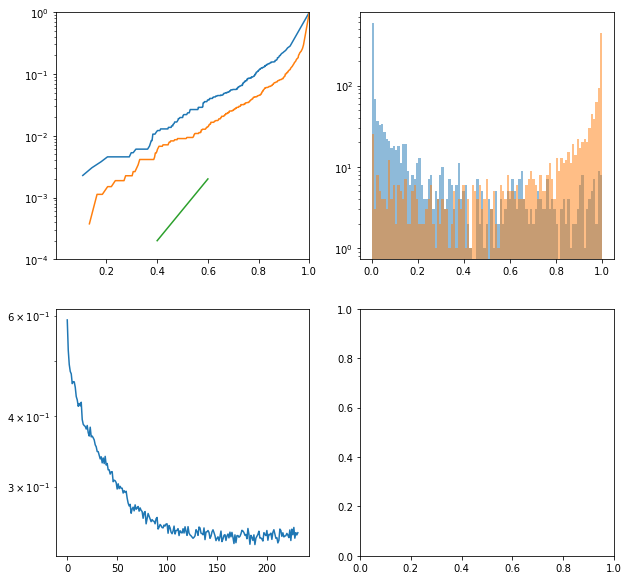

Adjusting learning rate of group 0 to 1.5259e-07.


KeyboardInterrupt: 

In [5]:
dataset=dataloader.dataset
model = GCN(hidden_channels=32).to(device)

#model = Net().to(device)
    
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = F.nll_loss

lrshed=torch.optim.lr_scheduler.StepLR(optimizer, 15, gamma=0.5, last_epoch=-1, verbose=True)

nep=1000
allloss=[]
allacc=[]

for ep in range(nep):
    lossarr=0.0
    accarr=0.0

    sigs=[[],[]]
    bkgs=[[],[]]
    for idata,data in enumerate(dataloader): 
             if (data.batch.max()+1!=batch_size):
                continue

             model.train()   
             alldat =  model(data)

             rando=torch.randn_like(data.x)*0.1
             #print(data.x+rando*data.x)
             data.x= data.x+rando*data.x
             traindat,traintrue = alldat[data.test_mask==0],(data.y)[data.test_mask==0]


             sigs[1].extend(traindat.exp()[traintrue==1].cpu().detach().numpy()[:,1])
             bkgs[1].extend(traindat.exp()[traintrue==0].cpu().detach().numpy()[:,1])
            
             loss = criterion(traindat, traintrue)
                
             optimizer.zero_grad()  
             loss.backward() 
             optimizer.step()  

            
             model.eval()  
             alldat =  model(data)

             testdat,testtrue = alldat[data.test_mask==1],(data.y)[data.test_mask==1]
             out = testdat.exp()
             #print (out)

             outmatch=out[testtrue>0.5][:,1]
             truematch=testtrue[testtrue>0.5]
             outmatch =torch.cat((outmatch,out[testtrue<0.5][:,0]))
             truematch=torch.cat((truematch,testtrue[testtrue<0.5]))
             #print (out.shape)
             #print (outmatch.shape)
           

             acc = binary_acc(outmatch, (truematch).to(device)) 
             #print (outmatch) 
             #print (truematch)
             sigs[0].extend(out[testtrue==1].cpu().detach().numpy()[:,1])
             bkgs[0].extend(out[testtrue==0].cpu().detach().numpy()[:,1])
             #print(sigs[0][-1],sigs[1][-1])
             #print(out.shape)
             #print(data.x)

             #print (data.x[out[data.y==0][:,1]>0.999])

             lossarr+=loss
             accarr+=acc
             #for zz in (zip(out, data.y)):
              #  print (zz)

    allloss.append((lossarr/idata).detach().cpu().numpy())
    allacc.append((accarr/idata).detach().cpu().numpy())

    bins = np.linspace(0, 1, 100)
    
    #summedtrue=[0]*len(bkgs)
    #summedtrue.extend([1]*len(sigs))
    #summedpred=copy.deepcopy(bkgs)
    #summedpred.extend(sigs)

    
    #rocby,rocbx,thresh=sklearn.metrics.roc_curve(summedtrue,summedpred, drop_intermediate=False)
    totb=[len(bkgs[0]),len(bkgs[1])]
    tots=[len(sigs[0]),len(sigs[1])]

    npoints=500
    bkgeff=[[],[]]
    sigeff=[[],[]]
    nsel=[1.0,1.0]
    ntot=[1.0,1.0]

    bkgmasseff=nsel[0]/ntot[0]
    sigmasseff=nsel[1]/ntot[1]
    
    print (totb,tots)
    #print (len(sigs))
    for ispl in range(2):
        for ith in range(npoints):
            thresh=float(ith/npoints)**(0.3)

            bkgeff[ispl].append(np.sum(np.array(bkgs[ispl])>thresh)/totb[ispl]*bkgmasseff)
            sigeff[ispl].append(np.sum(np.array(sigs[ispl])>thresh)/tots[ispl]*sigmasseff)
            #print (thresh)
            #print (bkgeff[ispl][-1], np.sum(np.array(bkgs[ispl])>thresh))
            #print (sigeff[ispl][-1], np.sum(np.array(sigs[ispl])>thresh))
            #print ()

    

    clear_output(wait=True)
    fig, axs = plt.subplots(2,2)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    axs[0][0].plot(sigeff[0],bkgeff[0])
    axs[0][0].plot(sigeff[1],bkgeff[1])
    axs[0][0].plot([0.6,0.4],[0.002,0.0002])
    axs[0][0].plot([0.6],[0.01])
    axs[0][0].set_xlim([0.0001, 1])
    axs[0][0].set_ylim([0.0001, 1])
    axs[0][0].set_yscale("log")

    axs[0][1].hist(bkgs[0], bins, alpha=0.5, label='x')
    axs[0][1].hist(sigs[0], bins, alpha=0.5, label='y')
    axs[0][1].set_yscale("log")
    
    axs[1][0].plot(np.array(allloss))
    axs[1][0].set_yscale("log")
   #axs[1][1].plot(np.array(allacc))

    #print (sigeff)
    #print (bkgeff)


    plt.pause(0.0001)
    lrshed.step()